In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline

In [3]:
results_folder = f'../data/results/'
#file_name_full_data = 'full_data_with_failure_marking.csv' 
#file_name_full_data = 'full_data_with_failure_and_pre-fault_marking.csv'
file_name_full_data = 'full_data_with_failure_and_all_pre-fault_marking.csv'

In [4]:
df = pd.read_csv(
    results_folder + file_name_full_data,
    index_col=False,
    header = 0,
)

### Data Cleaning and Preprocessing

In [6]:
# Features to consider
columns =  ['min', 'max', 'std', 'kurtosis', 'rms', 'skew', 'shannon_entropy']

In [7]:
df[columns].head()

,min,max,std,kurtosis,rms,skew,shannon_entropy
0,-0.183,0.029,0.072865,1.069163,0.124614,-0.029993,4.901797
1,-0.132,-0.068,0.025988,1.161552,0.123811,-0.070075,4.879316
2,-0.244,-0.044,0.067978,0.986286,0.125246,-0.041646,4.889290
3,-0.139,-0.017,0.046380,1.034294,0.125197,0.005162,4.897318
4,-0.227,-0.027,0.066552,1.110164,0.125618,-0.060196,4.912317


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46480 entries, 0 to 46479
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             46480 non-null  object 
 1   channel          46480 non-null  int64  
 2   min              46480 non-null  float64
 3   max              46480 non-null  float64
 4   std              46480 non-null  float64
 5   kurtosis         46475 non-null  float64
 6   shannon_entropy  46480 non-null  float64
 7   skew             46475 non-null  float64
 8   rms              46480 non-null  float64
 9   test             46480 non-null  int64  
 10  id               46480 non-null  object 
 11  class            46480 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 4.3+ MB


In [9]:
df[df.isna().any(axis=1)]

,time,channel,min,max,std,kurtosis,shannon_entropy,skew,rms,test,id,class
7114,2003-11-08 20:01:44,4,-0.149,0.022,0.059444,NaN,4.878939,NaN,0.140450,1,1_4_2003-11-08 20:01:44,0
9270,2003-11-08 20:01:44,5,-0.183,-0.007,0.067377,NaN,5.203651,NaN,0.158153,1,1_5_2003-11-08 20:01:44,0
11426,2003-11-08 20:01:44,6,-0.225,-0.039,0.071406,NaN,5.235471,NaN,0.161812,1,1_6_2003-11-08 20:01:44,0
13582,2003-11-08 20:01:44,7,-0.234,-0.039,0.062489,NaN,4.780331,NaN,0.134131,1,1_7_2003-11-08 20:01:44,0
15738,2003-11-08 20:01:44,8,-0.237,-0.063,0.064441,NaN,4.877073,NaN,0.139427,1,1_8_2003-11-08 20:01:44,0


Looks like 5 values for the stats have a NaN, since that's a small proportion of the ~46K values, we can drop them.

In [11]:
# Drop any NaNs
df.dropna(inplace = True)

### Target Variable

`class = 0` is negative class - i.e. no problem in the machinery.

`class = 1` is the positive class - i.e. problem is detected.

`class = 2` is another positive class - pre-fault detection state.

In [13]:
df['class'].value_counts(normalize=True)

class
0    0.922324
1    0.040108
2    0.037569
Name: proportion, dtype: float64

We note that we have a mismatched class - we will review later whether to pursue different strategies to resolve it.

In [15]:
# Features that are relevant to classification - we ignore those related to time, & test artifacts such as 
#   id, channel and test #
features_to_scale = df.drop(columns=['time', 'id', 'test', 'channel']).columns.tolist()  

In [16]:
X = df[features_to_scale].drop(columns = ['class'])

In [17]:
y = df['class']

In [18]:
X.head()

,min,max,std,kurtosis,shannon_entropy,skew,rms
0,-0.183,0.029,0.072865,1.069163,4.901797,-0.029993,0.124614
1,-0.132,-0.068,0.025988,1.161552,4.879316,-0.070075,0.123811
2,-0.244,-0.044,0.067978,0.986286,4.889290,-0.041646,0.125246
3,-0.139,-0.017,0.046380,1.034294,4.897318,0.005162,0.125197
4,-0.227,-0.027,0.066552,1.110164,4.912317,-0.060196,0.125618


- We divide the dataset into Training and Test sets at a 70:30 split. 

- In addition we shuffle the data since the positive classes are usually at the end of each experiment bunched together.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.3,
    shuffle=True,
    random_state = 123,
)

## Evaluate all Models for Classification

We will start with running each Classifier with default parameters or necessary defaults, for our Multinomial Classification problem. 

### Classifier `LogisticRegression`

In [23]:
estimator = LogisticRegression()

In [24]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('classifier', estimator)
])

In [25]:
# Now you can fit the pipeline on your data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier', LogisticRegression())])

In [26]:
y_preds = pipeline.predict(X_test)

In [27]:
rep = classification_report(y_test, y_preds)

In [28]:
print(rep)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     12861
           1       0.92      0.90      0.91       548
           2       0.70      0.24      0.35       534

    accuracy                           0.96     13943
   macro avg       0.86      0.71      0.75     13943
weighted avg       0.96      0.96      0.96     13943



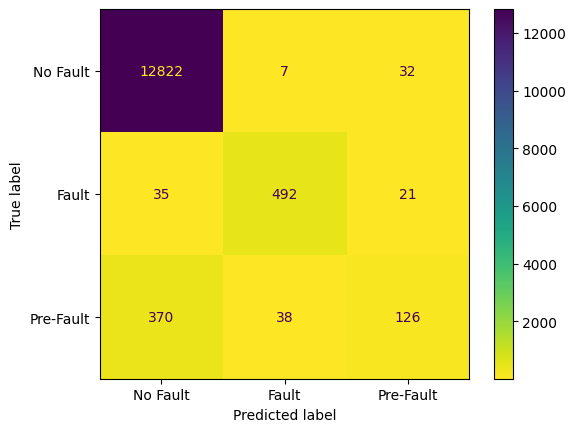

In [29]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

### Classifier - `SVM`

In [31]:
estimator = OneVsRestClassifier(SVC(gamma='auto', C = 10))

In [32]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('classifier', estimator)
])

In [33]:
# Now you can fit the pipeline on your data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier',
                 OneVsRestClassifier(estimator=SVC(C=10, gamma='auto')))])

In [34]:
y_preds = pipeline.predict(X_test)

In [35]:
rep = classification_report(y_test, y_preds, zero_division=0.0)

In [36]:
print(rep)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12861
           1       0.92      0.94      0.93       548
           2       0.89      0.46      0.61       534

    accuracy                           0.98     13943
   macro avg       0.93      0.80      0.84     13943
weighted avg       0.97      0.98      0.97     13943



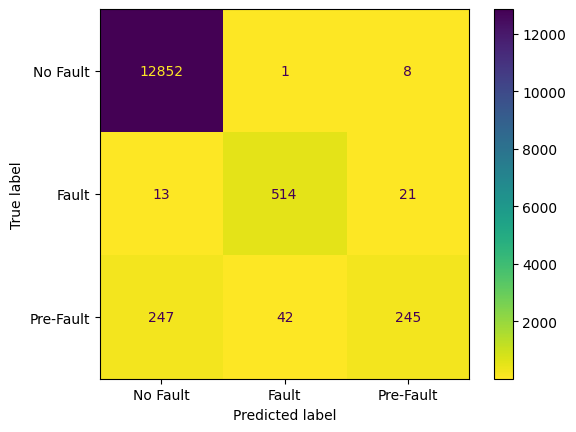

In [37]:
svc_cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

### `KNN` Classifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
model = KNeighborsClassifier(
    n_neighbors = 3,
    weights='distance',
)

In [41]:
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [42]:
y_preds = model.predict(X_test)

In [43]:
rep = classification_report(y_test, y_preds)

In [44]:
print(rep)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12861
           1       0.92      0.94      0.93       548
           2       0.81      0.56      0.66       534

    accuracy                           0.98     13943
   macro avg       0.91      0.83      0.86     13943
weighted avg       0.97      0.98      0.97     13943



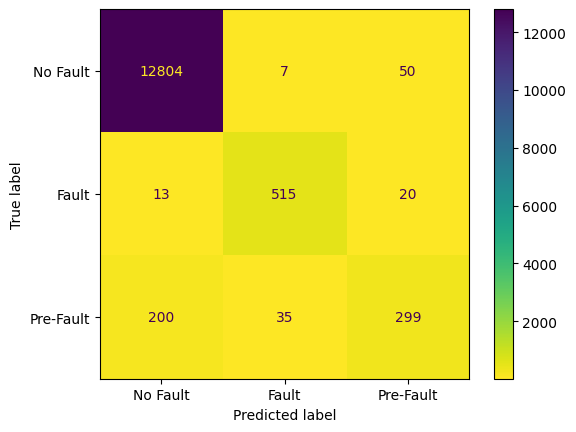

In [45]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

### `Decision Tree` Classifier

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
clf = DecisionTreeClassifier(criterion='entropy')

In [49]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [50]:
y_preds = model.predict(X_test)

In [51]:
rep = classification_report(y_test, y_preds)

In [52]:
print(rep)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12861
           1       0.92      0.94      0.93       548
           2       0.81      0.56      0.66       534

    accuracy                           0.98     13943
   macro avg       0.91      0.83      0.86     13943
weighted avg       0.97      0.98      0.97     13943



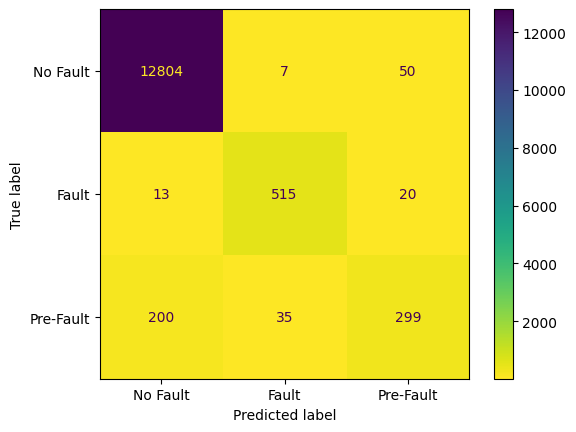

In [53]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

### Ensemble Technique - `RandomForestClassifier`

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
classifier = RandomForestClassifier(oob_score=True)

In [57]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('classifier', classifier)
])

In [58]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier', RandomForestClassifier(oob_score=True))])

In [59]:
pipeline.named_steps['classifier'].oob_score_

0.9809725808434772

In [60]:
y_preds = pipeline.predict(X_test)

In [61]:
rep = classification_report(y_test, y_preds)
print(rep)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12861
           1       0.94      0.96      0.95       548
           2       0.87      0.63      0.73       534

    accuracy                           0.98     13943
   macro avg       0.93      0.86      0.89     13943
weighted avg       0.98      0.98      0.98     13943



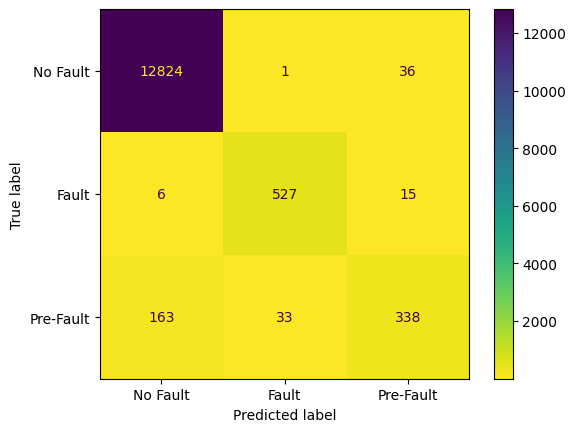

In [62]:
rfc_cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

In [171]:
rfc_cm_display.figure_.savefig('../images/rfc_initial_conf_matrix.png', dpi=300)

### Ensemble Technique - `GradientBoostingClassifier`

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

In [65]:
classifier = GradientBoostingClassifier()

In [66]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('classifier', classifier)
])

In [67]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier', GradientBoostingClassifier())])

In [68]:
y_preds = pipeline.predict(X_test)

In [69]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12861
           1       0.93      0.97      0.95       548
           2       0.91      0.58      0.71       534

    accuracy                           0.98     13943
   macro avg       0.94      0.85      0.88     13943
weighted avg       0.98      0.98      0.98     13943



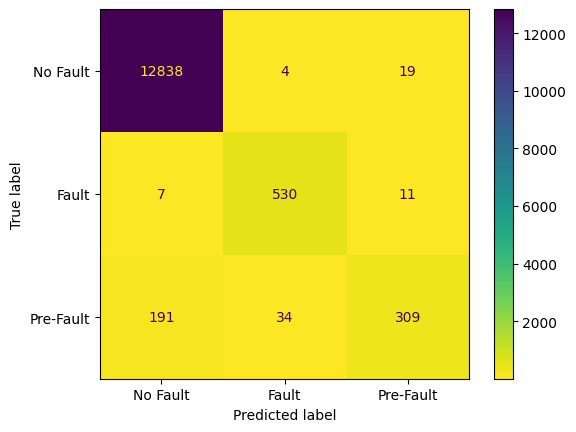

In [70]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

### Ensemble Technique - `XGBoost`

In [72]:
from xgboost import XGBClassifier

In [73]:
bst = OneVsRestClassifier(
    XGBClassifier(
        num_class = 3,
        objective='multi:softprob',
    )
)

In [74]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('classifier', bst)
])

In [75]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier',
                 OneVsRestClassifier(estimator=XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_class=3,
                                                             num_parallel_tree=None, ...)))])

In [76]:
y_preds = pipeline.predict(X_test)

In [77]:
print(classification_report(y_test, y_preds, zero_division=0.0))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12861
           1       0.94      0.96      0.95       548
           2       0.88      0.68      0.77       534

    accuracy                           0.98     13943
   macro avg       0.94      0.88      0.90     13943
weighted avg       0.98      0.98      0.98     13943



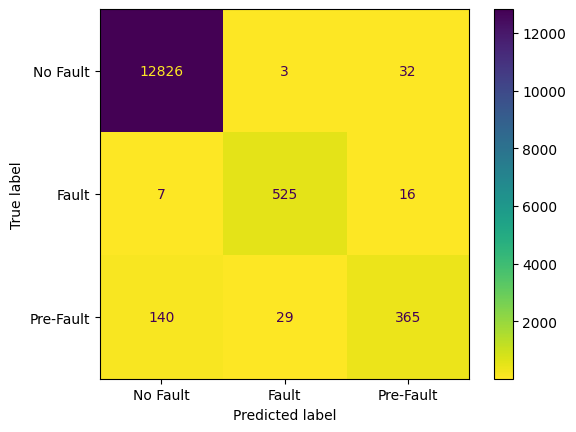

In [78]:
xgb_cm_display = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_preds,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)

In [173]:
xgb_cm_display.figure_.savefig('../images/xgb_initial_conf_matrix.png', dpi=300)

## Deep Learning Models

### `CNN` Classification 

In [80]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [81]:
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

In [82]:
stopper = EarlyStopping(patience = 4)

In [83]:
model = Sequential(
    [
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.1),
        Dense(50, activation='relu'),
        Dense(3, activation="softmax"),
    ]
)

In [84]:
model.compile(
    loss="categorical_crossentropy", 
    metrics=["categorical_accuracy"], # sparse_categorical_accuracy
)

In [85]:
history = model.fit(
    X_train, 
    y_train_ohe, 
    epochs = 100, 
    batch_size = 64, 
    validation_data=(X_test, y_test_ohe),
    callbacks = stopper,
    verbose = 0,
)

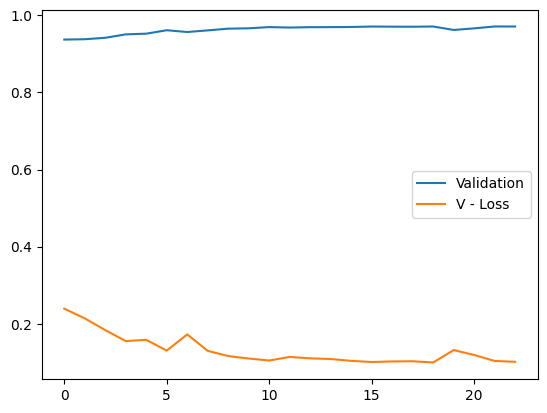

In [86]:
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation')
plt.plot(history.history['val_loss'], label = 'V - Loss')
plt.legend()

In [87]:
history.history['val_categorical_accuracy'][-1]

0.9706662893295288

In [88]:
y_preds = model.predict(X_test)

436/436 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step


In [89]:
y_preds_binary = np.argmax(y_preds, axis=1)

In [90]:
rep = classification_report(y_test, y_preds_binary)
print(rep)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     12861
           1       0.95      0.88      0.91       548
           2       0.82      0.40      0.54       534

    accuracy                           0.97     13943
   macro avg       0.92      0.76      0.81     13943
weighted avg       0.97      0.97      0.97     13943



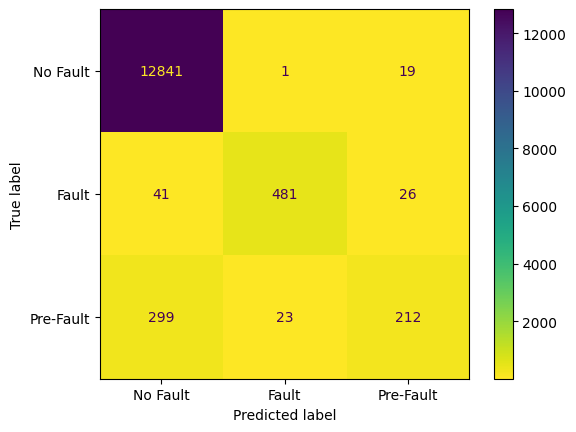

In [91]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_preds_binary,
    display_labels=['No Fault', 'Fault', 'Pre-Fault'],  # 0: No Fault, 1 : Fault, 2: Pre-Fault
    cmap = 'viridis_r',
)